In [25]:
#Method for calculating Markov transition matrix with nice steady state properties... minimise sq err
srand(1)
using JuMP, CPLEX, StatsBase, HDF5, JLD



function Transition()
    rawData = round(readcsv("countryRowGrowth.csv"),2)

    global data = zeros(1,2)

    nCountries = size(rawData)[1]
    nYears = size(rawData)[2]

    minGrid = .9
    maxGrid = 1.1
    increment = .01
    
    global nStates = length(minGrid:increment:maxGrid)

    
    function valueToIndex(value)

        global index = round((value - minGrid)/increment + 1,0)

    end

    global vGrowthGrid = collect(minGrid:increment:maxGrid)
    global nGrowthGrid = length(vGrowthGrid)

    growthMat = zeros(nCountries, nYears)

    for m = 1:nCountries
        for n = 1:nYears
            if rawData[m,n] < 1000000
                growthMat[m,n] = vGrowthGrid[indmin(abs(vGrowthGrid .- rawData[m,n]))]
            end
        end
    end

    global markov = zeros(nGrowthGrid,nGrowthGrid)



    for i = 1:nCountries
        for j = 1:nYears-1
            if rawData[i,j] < 1000000
                if rawData[i,j+1] < 1000000

                    x = convert(Int64,valueToIndex(growthMat[i,j]))
                    y = convert(Int64,valueToIndex(growthMat[i,j+1]))
                    
                    data= vcat(data, [valueToIndex(growthMat[i,j]), valueToIndex(growthMat[i,j+1])]')

                    markov[x,y] +=1
                end
            end

        end
    end

    for k = 1:nGrowthGrid
        markov[k,:] = markov[k,:]./sum(markov[k,:])
    end


    data = data[2:end,:]
    global tallyState = hist(data[:,1], 1-.5:1:nStates+.5)[2]
    global s = tallyState/sum(tallyState)
end
Transition()
#mTransition is what we're shooting for
#vGrowthGrid is "rates" in the exstimation code



nStates = length(s)

states = collect(1:length(vGrowthGrid))


data = rand(1:nStates, 4000,2)
nData = size(data)[1]

#for i = 1:1000
#    data[i,1:2] = [states[rand(1:end)],states[rand(1:end)]]
#end

M = length(vGrowthGrid)
N = length(vGrowthGrid)

ONE = ones(M)

m = Model(solver = CplexSolver())

@variable(m, 0 <= T[1:M,1:N] <= 1)

@variable(m, topObj)



one = ones(M)
i = 1:M



@constraint(m, T'*s .== s)

@constraint(m, T*ONE .== ONE)

#@constraint(m, T .<= ones(M,M))
#@constraint(m, T .>= zeros(M,M))


@constraintref constraintFOSD[1:M]
for i = 1:M-1
    j = 1:M
    #constraintFOSD[i] = @constraint(m, sum(T[i,j]*rates[j]) <= sum(T[i+1,j]*rates[j]))
end

@constraint(m, T[1:M-1,:]*vGrowthGrid .<= T[2:M,:]*vGrowthGrid)

topObjVal = 0
#for a = 1:nData
    #topObjVal += @expression(m, ref, T[data[a,1], data[a,2]] - log(1+e.^T[data[a,1], data[a,2]]))
#    topObjVal += @expression(m,ref, T[data[a,1], data[a,2]] - )
#end

#what we shoot for
empDist = zeros(M,M)
for i = 1:nData

    x = data[i,1]
    y = data[i,2]

    if M >= x >= 1
        if M >= y >= 1
            empDist[x,y] +=1
        end
    end
end

for k = 1:M
    if sum(empDist[k,:]) >=0
    empDist[k,:] = empDist[k,:]./sum(empDist[k,:])
    else
        empDist[k,:] = 0
    end
    
end

#quadratic penalty function... can be changed to normal or something
for a = 1:nData
    topObjVal += @expression(m, ref, (T[states[data[a,1]], states[data[a,2]]] - empDist[states[data[a,1]], states[data[a,2]]])^2)
end

@constraint(m, topObj == topObjVal)


@objective(m, Min, topObj) 
solve(m)
#getdual(T)
mTransition = getvalue(T)[1:M,1:M]


#8/29 "Endogenous" Discounting




 in depwarn(::String, ::Symbol) at .\deprecated.jl:64
 in #hist!#1016(::Bool, ::Function, ::Array{Int64,1}, ::Array{Float64,1}, ::FloatRange{Float64}) at .\deprecated.jl:630
 in hist(::Array{Float64,1}, ::FloatRange{Float64}) at .\deprecated.jl:645
 in Transition() at .\In[25]:68
 in include_string(::String, ::String) at .\loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at C:\Users\Ryan\.julia\v0.5\IJulia\src\execute_request.jl:157
 in eventloop(::ZMQ.Socket) at C:\Users\Ryan\.julia\v0.5\IJulia\src\eventloop.jl:8
 in (::IJulia.##13#19)() at .\task.jl:360
while loading In[25], in expression starting on line 71


21×21 Array{Float64,2}:
 0.0731047    0.0275021    0.0311383    …  0.027591   0.0631093  0.0399542
 0.0641552    0.0678561    0.0400029       0.0509748  0.0553775  0.057093 
 0.0562968    0.0297712    0.0352551       0.0564753  0.0333804  0.0512379
 0.0488656    0.040037     0.0236891       0.0517331  0.0727     0.0375303
 0.0404378    0.0389177    0.0174857       0.0324483  0.0388877  0.0648234
 0.0457768    0.0366538    0.000522922  …  0.0648185  0.0271435  0.0673305
 0.0373156    0.00337359   0.0293579       0.0473028  0.0370059  0.045061 
 0.0269254    0.00600914   0.0399344       0.0684189  0.0530487  0.0532206
 0.0134643    0.0199935    8.25946e-12     0.0606806  0.0540568  0.0541698
 0.0106778    4.03609e-12  1.14326e-11     0.05948    0.0309995  0.071164 
 0.0180159    2.44326e-12  0.000815851  …  0.0566606  0.0647987  0.0583766
 0.0010883    0.00299238   2.30502e-12     0.0640233  0.0424837  0.0728354
 0.017073     1.36682e-12  1.62281e-12     0.0347236  0.0189644  0.0816464
 

Tried aggregator 1 time.
QP Presolve eliminated 0 rows and 2 columns.
Reduced QP has 62 rows, 441 columns, and 1722 nonzeros.
Reduced QP objective Q matrix has 441 nonzeros.
Presolve time = 0.02 sec. (0.28 ticks)
Parallel mode: using up to 4 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 920
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.04 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 4
  Rows in Factor            = 62
  Integer space required    = 128
  Total non-zeros in factor = 1460
  Total FP ops to factor    = 41456
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0  3.9582516e+005 -4.0084786e+005 6.26e+003 8.38e+003 8.00e+004
   1  3.3244363e+001 -7.5456667e+002 5.76e+001 7.71e+001 7.37e+002
   2  5.3490921e+000 -2.0175238e+002 1.54e+001 2.06e+001 1.96e+002
   3  3.7661432e+000 -5.3181152e+001 4.23e+000 5.66e+000 5.42e+001
   4  3.7867081e+000 -1.754481

In [42]:
using PyPlot, StatsBase, HDF5, JLD



    ##  1. Calibration
    r0 = .04#.03#
    
    #bbeta  = 1/(1+r0)    # Discount factor
    eta = 0#1#
    

    sigma = 1.5#2#
    gamma = .204
    t = .25#.4#
    phi =.62#.95#
    vGridU = sort(collect(6.5:.1:6.5), rev = true)
    nGridU = length(vGridU)
    vSqErr = zeros(nGridU)
    bbar = 1.7#2.1#
    nGridProductivitySample = 21
    due = 1#3#
    # Productivity values
    

    
    riData = readcsv("IntDebtGreece.csv")#readcsv("IntDebtEuro.csv")#
    empDistBonds =  riData[:,2]./100
    
    empDistGDP = vGrowthGrid
    global vGridProductivity = t*sort(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true))#t*sort(vcat(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true),.7:.01:1))#
    
    lenData = size(empDistBonds)[1]
    Err = zeros(lenData)
    sqErr = zeros(lenData)
    global nGridProductivity = length(vGridProductivity)

    # Transition matrix

    #println("Output = ",outputSteadyState," Capital = ",capitalSteadyState," Government Spending = ",govspendingSteadyState)

    # We generate the grid of bonds
    global vGridBonds = sort(vcat(empDistBonds,collect(.01:.01:bbar)))#sort(vcat(.01:.02:bbar, empDistBonds))
    global nGridBonds = length(vGridBonds)
    global nBondProd = nGridBonds*nGridProductivity

    #convert(UInt64, nGridRenegot)
    
    findU = zeros(nGridBonds,nGridU)
    vGridABar = 1:nGridBonds
    global riAbar = ones(Int, nGridBonds, nGridU) #this is the index of the "reservation default at level of bond holdings
    bbeta = ones(nGridBonds)
    
    newriAbar = ones(Int, nGridBonds, nGridU)
    global ri = zeros(nGridBonds, nGridProductivity, nGridU)
    repayTot = zeros(nGridBonds,nGridProductivity)
    vec = zeros(due,nGridBonds)
    
    global nGridPrductivity = length(vGridProductivity)
    
    function restructure(bonds)
        differenceSq = zeros(nGridBonds)
        for currentDebt = 1:nGridBonds
            differenceSq[currentDebt] = abs(vGridBonds[currentDebt] - phi*vGridBonds[bonds])
        end
        global renegotIndex = findmin(differenceSq)[2]
        global renegotValue = findmin(differenceSq)[1]
    end 

    restructure(nGridBonds)
    maxRenegot = renegotValue
    nGridRenegot = renegotIndex
    
    # 3. Required matrices and vectors

    #mOutput           = zeros(nGridCapital,nGridProductivity)
    mValueFunction    = load("VSU 183x21.jld")["VSU 183x21"]
    VD = ones(nGridRenegot, nGridProductivity)
    
    #store results for each U
    global VSU = reshape(load("VSU 183x21.jld")["VSU 183x21"], 183,21,1)#zeros(nGridBonds, nGridProductivity, nGridU)
    global VDU = reshape(load("VDU 105x21.jld")["VDU 105x21"], 105,21,1)#zeros(nGridRenegot, nGridProductivity, nGridU)
    global PolicyU = zeros(nGridBonds,nGridProductivity,nGridU)
    global PolicyUIndex = zeros(Int, nGridBonds,nGridProductivity,nGridU)
    global tauU = zeros(nGridBonds, nGridProductivity, nGridU)
    
    mValueFunctionNew = load("VSU 183x21.jld")["VSU 183x21"]
    mPolicyFunction   = zeros(nGridBonds,nGridProductivity)
    global mPolicyFunctionIndex = zeros(Int, nGridBonds,nGridProductivity)
    expectedValueFunction = zeros(nGridBonds,nGridProductivity)
    
    global tau = zeros(nGridBonds, nGridProductivity, nGridU)
    global mDefault = zeros(nGridBonds, nGridProductivity,nGridU)



   
    # 4. We pre-build output for each point in the grid

    #mOutput = (vGridCapital.^aalpha)*vGridProductivity;

    # 5. Main iteration


function main(theta)
    
    omega = theta
    ##  1. Calibration
    r0 = .04#.03#
    
    #bbeta  = 1/(1+r0)    # Discount factor
    eta = 0#1#
    

    sigma = 1.5#2#
    gamma = .204
    t = .25#.4#
    phi =.62#.95#
    vGridU = sort(collect(6.5:.1:6.5), rev = true)
    nGridU = length(vGridU)
    vSqErr = zeros(nGridU)
    bbar = 1.7#2.1#
    nGridProductivitySample = 21
    due = 1#3#
    # Productivity values
    

    
    riData = readcsv("IntDebtGreece.csv")#readcsv("IntDebtEuro.csv")#
    empDistBonds =  riData[:,2]./100
    
    empDistGDP = vGrowthGrid
    global vGridProductivity = t*sort(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true))#t*sort(vcat(sample(empDistGDP, nGridProductivitySample, replace=false, ordered=true),.7:.01:1))#
    
    lenData = size(empDistBonds)[1]
    Err = zeros(lenData)
    sqErr = zeros(lenData)
    global nGridProductivity = length(vGridProductivity)

    # Transition matrix

    #println("Output = ",outputSteadyState," Capital = ",capitalSteadyState," Government Spending = ",govspendingSteadyState)

    # We generate the grid of bonds
    global vGridBonds = sort(vcat(empDistBonds,collect(.01:.01:bbar)))#sort(vcat(.01:.02:bbar, empDistBonds))
    global nGridBonds = length(vGridBonds)
    global nBondProd = nGridBonds*nGridProductivity

    #convert(UInt64, nGridRenegot)
    
    findU = zeros(nGridBonds,nGridU)
    vGridABar = 1:nGridBonds
    global riAbar = ones(Int, nGridBonds, nGridU) #this is the index of the "reservation default at level of bond holdings
    bbeta = ones(nGridBonds)
    
    newriAbar = ones(Int, nGridBonds, nGridU)
    global ri = zeros(nGridBonds, nGridProductivity, nGridU)
    repayTot = zeros(nGridBonds,nGridProductivity)
    vec = zeros(due,nGridBonds)
    
    global nGridPrductivity = length(vGridProductivity)
    
    function restructure(bonds)
        differenceSq = zeros(nGridBonds)
        for currentDebt = 1:nGridBonds
            differenceSq[currentDebt] = abs(vGridBonds[currentDebt] - phi*vGridBonds[bonds])
        end
        global renegotIndex = findmin(differenceSq)[2]
        global renegotValue = findmin(differenceSq)[1]
    end 

    restructure(nGridBonds)
    maxRenegot = renegotValue
    nGridRenegot = renegotIndex
    
    # 3. Required matrices and vectors

    #mOutput           = zeros(nGridCapital,nGridProductivity)
    mValueFunction    = load("VSU 183x21.jld")["VSU 183x21"]
    VD = ones(nGridRenegot, nGridProductivity)
    
    #store results for each U
    global VSU = reshape(load("VSU 183x21.jld")["VSU 183x21"], 183,21,1)#zeros(nGridBonds, nGridProductivity, nGridU)
    global VDU = reshape(load("VDU 105x21.jld")["VDU 105x21"], 105,21,1)#zeros(nGridRenegot, nGridProductivity, nGridU)
    global PolicyU = zeros(nGridBonds,nGridProductivity,nGridU)
    global PolicyUIndex = zeros(Int, nGridBonds,nGridProductivity,nGridU)
    global tauU = zeros(nGridBonds, nGridProductivity, nGridU)
    
    mValueFunctionNew = load("VSU 183x21.jld")["VSU 183x21"]
    mPolicyFunction   = zeros(nGridBonds,nGridProductivity)
    global mPolicyFunctionIndex = zeros(Int, nGridBonds,nGridProductivity)
    expectedValueFunction = zeros(nGridBonds,nGridProductivity)
    
    global tau = zeros(nGridBonds, nGridProductivity, nGridU)
    global mDefault = zeros(nGridBonds, nGridProductivity,nGridU)



   
    # 4. We pre-build output for each point in the grid

    #mOutput = (vGridCapital.^aalpha)*vGridProductivity;

    # 5. Main iteration
    UIndex = 0

    for UIndex = 1:nGridU 
        ubar = vGridU[UIndex]
        riDiff = 1

        while riDiff > 0 
            maxDifference = 10.0
            tolerance = .01
            iteration = 0
            
            a = 0
            for a = 1:nGridBonds
                for b = 1:nGridProductivity
                    ri[a, b, UIndex] = ((1+r0 - phi*(1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]]))/
                    (1 - (1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]])) - 1)
                    #(1+r0)/(1 - (riAbar[a]-1)*(1 - omega)/nGridProductivity)-1
                    for i = 1:due
                        vec[i,:] = (1/due) ./((1+ri[a,b, UIndex]).^i)
                    end
                
                
                repayTot[a,b] = 1 ./sum(vec[:,a])
                
                bbeta[a] = (1 - eta*(1-omega)*sum(mTransition[b,1: riAbar[a, UIndex]]))/(1 + r0)
                end
            end
            


            while(maxDifference > tolerance)
                defprod = 0
                
                
                
                expectedValueFunction = mValueFunction*mTransition';
                expectedProductivity = vGridProductivity'*mTransition
                bondsChoice  = copy(vGridBonds[1])
                bondsChoiceIndex = 1
                
                for count = 1:50
                    expectedVD = VD*mTransition'
                    for renegotiatedDebt = 1:nGridRenegot
                        for defprod =  1:nGridProductivity # all default productivity levels... could actually reduce nGridProd to the highest level where default happens
                            defspend = vGridProductivity[defprod]::Float64


                            VD[renegotiatedDebt,defprod] = ((defspend^(1 - sigma))/(1 - sigma) + bbeta[nGridBonds] * 
                            gamma * expectedValueFunction[renegotiatedDebt,defprod] +
                            bbeta[nGridBonds]*(1 - gamma)*expectedVD[renegotiatedDebt, defprod])
                        end
                    count = count+1
                    
                    end
                end
                nProductivityToday = 0
                for nProductivityToday = 1:nGridProductivity
                    nBondsToday = 0
                    for nBondsToday = 1:nGridBonds
                        restructure(nBondsToday)
                        valueHighSoFar = -100000000000
                        nBondsNextPeriod = 0
                        for nBondsNextPeriod = 1:nGridBonds
                                
                            if nProductivityToday > riAbar[nBondsToday, UIndex] - 1
                                
                                TodTomDebtDiff = vGridProductivity[nProductivityToday]*vGridBonds[nBondsNextPeriod]/t - ((due - 1)/due)vGridBonds[nBondsToday]
                                
                                
                                leftForCons = TodTomDebtDiff/(repayTot[nBondsNextPeriod,nProductivityToday])
                                
                                
                                govspend = vGridProductivity[nProductivityToday] - (1/due)*vGridBonds[nBondsToday] + leftForCons
                               

                                if govspend>0
                                    valueProvisional = ((govspend^(1 - sigma)) /(1 - sigma)
                                    + bbeta[nBondsNextPeriod]*expectedValueFunction[nBondsNextPeriod,nProductivityToday])
                                else  
                                    valueProvisional = VD[renegotIndex,nProductivityToday] - ubar
                                    bondsChoiceIndex = renegotIndex
                                    bondsChoice = vGridBonds[renegotIndex]
                                end

                                if valueProvisional > valueHighSoFar

                                    valueHighSoFar = copy(valueProvisional)
                                    bondsChoice = copy(vGridBonds[nBondsNextPeriod])
                                    bondsChoiceIndex = copy(nBondsNextPeriod)
                                end
                            else
                                valueHighSoFar = VD[renegotIndex, nProductivityToday] - ubar
                                bondsChoice = vGridBonds[renegotIndex] # this isn't true if saved by IMF, need to calc new bond holdings
                                bondsChoiceIndex = renegotIndex
                            end
                        end
                        mValueFunctionNew[nBondsToday,nProductivityToday] = copy(valueHighSoFar)
                        mPolicyFunction[nBondsToday,nProductivityToday] = copy(bondsChoice)
                        mPolicyFunctionIndex[nBondsToday,nProductivityToday] = copy(bondsChoiceIndex)
                        
                    end
                end

                for count = 1:10
                    expectedVD = VD*mTransition'
                    for carriedDebt = 1:nGridRenegot
                        for defprod =  1:nGridProductivity # all default productivity levels... could actually reduce nGridProd to the highest level where default happens
                            defspend = vGridProductivity[defprod]::Float64

                            VD[carriedDebt, defprod] = ((defspend^(1 - sigma))/(1 - sigma) + bbeta[nGridBonds] *
                            gamma * expectedValueFunction[carriedDebt,defprod] +
                            bbeta[nGridBonds]*(1 - gamma)*expectedVD[carriedDebt, defprod])
                        end
                    end
                    count = count+1
                end
                
                
                maxDifference  = maximum(abs(mValueFunctionNew - mValueFunction))
                #println(mValueFunctionNew-mValueFunction)
                mValueFunction    = copy(mValueFunctionNew)
                iteration = iteration+1
                mValueFunctionNew = zeros(nGridBonds, nGridProductivity)




                #if mod(iteration,10)==0 #|| iteration == 1
                #    println("UINdex", UIndex, " Iteration = ", iteration, " Sup Diff = ", maxDifference)
                #end    
            end

            risk = 0
            riDiff = 0
            for risk = 1:nGridBonds #risk is index of bonds today
                restructure(risk)
                expectedValueFunction = mValueFunction*mTransition'
                expectedVD = VD*mTransition'
                if riAbar[risk, UIndex] < nGridProductivity 
                    
            
                    
                    TodTomDebtDiff =  vGridProductivity[riAbar[risk,UIndex]]*mPolicyFunction[risk,riAbar[risk, UIndex]]/t - ((due - 1)/due)*vGridBonds[risk]
                                
                    leftForCons = TodTomDebtDiff./(repayTot[mPolicyFunctionIndex[risk,riAbar[risk, UIndex]]])
                                
                    
                    spend = vGridProductivity[riAbar[risk, UIndex]] - (1/due)*vGridBonds[risk] + leftForCons

                    
                    
                    
                    #spend = (vGridProductivity[riAbar[risk]] - vGridBonds[risk] + mPolicyFunction[risk,riAbar[risk]]./(1+
                    #ri[mPolicyFunctionIndex[risk,riAbar[risk]]]))
                    
                    #expConTomSol = vGridProductivity - vGridBonds[risk] + mPolicyFunction'[risk,:]./(ri[mPolicyFunction'[risk,:]])
                    #expConTomDef = vGridProductivity
                    if spend >0
                        forcedSol = ((spend[1]^(1 - sigma))./(1 - sigma) + bbeta[risk]*expectedValueFunction[mPolicyFunctionIndex[risk,riAbar[risk, UIndex]],
                            riAbar[risk, UIndex]] )
                    else
                        forcedSol = -100000000
                    end

                    forcedDef = (((vGridProductivity[riAbar[risk, UIndex]])^(1 - sigma))/(1 - sigma) +
                    bbeta[nGridBonds]*expectedVD[renegotIndex,riAbar[risk, UIndex]] - ubar)

                    if forcedSol[1] <= forcedDef[1]
                        #newriAbar[risk:nGridBonds] = min(riAbar[risk:nGridBonds] + ones(nGridBonds - risk + 1),nGridProductivity*ones(nGridBonds 
                        #- risk + 1))
                        newriAbar[risk, UIndex] = min(newriAbar[risk, UIndex] + 1, nGridBonds)
                        if risk>1
                            for increase =  risk:nGridBonds-1
                                if  newriAbar[increase, UIndex] > newriAbar[increase + 1, UIndex]
                                    newriAbar[increase + 1, UIndex:nGridU] += 1
                                end
                            end
                        end
                        #if risk > 1
                        #    newriAbar = vcat(riAbar[1:(risk - 1)], min(min(riAbar[risk:nGridBonds] + 1,ones(nGridBonds - risk + 1)*nGridProductivity),
                        #    ones

                        #else
                        #    newriAbar = min(riAbar + 1,nGridProductivity)
                        #end

                    else
                        newriAbar[risk, UIndex:nGridU] = copy(riAbar[risk, UIndex])
                    end
                    
                else
                    newriAbar[risk, UIndex:nGridU] = nGridProductivity
                    
                    #riDiff = 0
                    #break #cannot raise the cuttoff any higher
                end
                riDiff = abs(sum(newriAbar - riAbar)) + riDiff
                riAbar = copy(newriAbar)
            end
            #newriAbar = ones(nGridBonds)
            #println("Change in Ri = ", riDiff, "UIndex = ", UIndex," RiMaxBonds = ", riAbar[nGridBonds, UIndex])
            end    
        
        m = 1
        n = 1
        
        for m = 1:nGridBonds
            for n = 1:nGridProductivity
                if riAbar[m, UIndex] > n
                    mDefault[m,n,UIndex] = 1
                end
            end
        end
        #println("mdefault ")
        #find level of bonds s.t no default ever happens maxSolBonds
        maxSolBonds = zeros(nGridProductivity)
        x = 1
        y = 1
        for x = 1:nGridProductivity
            for y = 1:nGridBonds
                restructure(y)
                if x >= riAbar[y, UIndex]
                    maxSolBonds[x] = y
                else
                    maxSolBonds[x] = renegotIndex
                end

            end
        end
        #println("max solvent bonds ")
        p = 1
        q = 1
        #calculate necessary payment tau
        #need to put this in a 3D matrix to call back later, along with VS, VD
        
        for p = 1:nGridBonds
            restructure(p)
            for q = 1:nGridProductivity
                if riAbar[p, UIndex] > q
                    tau[p,q,UIndex] = vGridBonds[renegotIndex]
                end
            end
        end
        global aveTau = omega*mean(tau)
        #println("Average tau paid ", aveTau)
        #phi[OmegaChoice] = ((1+aveTau)^(1 - sigma)/(1 - sigma) - 1/(1-sigma))
        #plot(1:nGridBonds,mValueFunction[1:nGridBonds,10],color = "blue")
        #plot(1:nGridBonds,riAbar, color = "red")


        #place ri results into matrix
            findU[:, UIndex] = ri[:,1, UIndex] #need to find interest rates as function of gdp match in data!
        dataInd = 0
        for dataInd = 1:lenData
            dataIndInComp= find(vGridBonds.==empDistBonds[dataInd])[1]
            Err[dataInd] = ri[dataIndInComp[1],nGridProductivity, UIndex] - riData[dataInd,1]./100
        end
        
        VSU[:,:,UIndex] = mValueFunction
        VDU[:,:,UIndex] = VD - ubar
        PolicyU[:,:,UIndex] = mPolicyFunction
        PolicyUIndex[:,:,UIndex] = mPolicyFunctionIndex
        tauU[:,:,UIndex] = tau[:,:,UIndex]
        
        sqErr = Err'*Err
 
        vSqErr[UIndex] = sqErr[1]

    end
    

    global vSqErr = -vSqErr'
    
    #Steady State Bonds Distribution

    global optimalUIndex = findmax(vSqErr)[2]
    global uii = vGridU[optimalUIndex]
    global bondsTodayToTomorrowProb = zeros(nGridBonds,nGridBonds)
    
    ssTransition = mTransition^10000
    
    global muBondsProd = zeros(nGridProductivity*nGridBonds, nGridProductivity*nGridBonds)
    global penaltyBox = zeros(nGridProductivity*nGridBonds, nGridProductivity*nGridBonds)
    
    for bToday = 1:nGridBonds
        for gToday = 1:nGridProductivity
            for bTom = 1:nGridBonds
                for gTom = 1:nGridProductivity
                    if mDefault[bToday, gToday] == 1
                        penaltyBox[(nGridProductivity)*(bToday-1) + gToday, (nGridProductivity)*(bTom-1) + gTom] = ((1 - theta) * 
                        mTransition[gToday,gTom])
                    end
                    if PolicyUIndex[bToday,gToday] == bTom
#row of bonds to bonds matrix is the tally function, check to be sure that prime is working
                        muBondsProd[(nGridProductivity)*(bToday-1) + gToday, (nGridProductivity)*(bTom-1) + gTom] += mTransition[gToday,gTom]
                       # - penaltyBox[(nGridProductivity)*(bToday-1) + gToday, (nGridProductivity)*(bTom-1) + gTom])
                    end
                end
            end
        end
    end
    

    
    global muBonds = (bondsTodayToTomorrowProb)^10000
    #Suspicious
    
    #println("Uii = ", uii)
    grVSU = VSU[nGridBonds,:, optimalUIndex]
    grVDU = VDU[nGridRenegot,:, optimalUIndex]
    plot(vGridProductivity, grVSU, color = "black")
    plot(vGridProductivity,grVDU, color = "red")
end

main (generic function with 1 method)

.


In [ ]:
using PyPlot

function findBond(bonds)
    differenceSq = zeros(nGridBonds)
    for currentDebt = 1:nGridBonds
        differenceSq[currentDebt] = abs(vGridBonds[currentDebt] - bonds)
    end
    global findBondIndex = findmin(differenceSq)[2]
    global findBondGrow = findmin(differenceSq)[1]
end 

function calcPerDef(range)
    
    
    nGridBond = nGridBonds*nGridProductivity
    global omegaEpsilonGrid = range
    global nOEGrid = length(omegaEpsilonGrid)
    global perInDefault = zeros(nOEGrid)
    global perDefaultingThisYear = zeros(nOEGrid)

    global perThreatening = zeros(nOEGrid)
    global ssMuVec = zeros(nBondProd)
    #+epsilon, -epsilon, true
    global mDefaultVec = reshape((mDefault[:,:,1])',1,nBondProd) #should probably be mDefault'
    global mValue = zeros(nGridBonds,nGridProductivity, nOEGrid)
    
    muBondsProdAdj = zeros(nBondProd,nBondProd)
    penaltyBoxAdj = zeros(nBondProd,nBondProd)
    penaltyBoxShaker = zeros(nBondProd, nBondProd)
    free = zeros(nBondProd,nBondProd)
    freeNew = zeros(nBondProd,nBondProd)
    
    
    fixed = zeros(nBondProd,nBondProd)
    fixedNew = zeros(nBondProd,nBondProd)
    
    for omegaEpsilonIndex = 1:nOEGrid
        omegaEpsilon = omegaEpsilonGrid[omegaEpsilonIndex]
        main(omegaEpsilon)
        mValue[:,:,omegaEpsilonIndex] = VSU[:,:,optimalUIndex]

        nBondProd = length(muBondsProd[1,:])
        A = zeros(nBondProd)
        for i = 1:nBondProd
            A[i] = sum(muBondsProd[i,:])
        end

        
        for j = 1:nBondProd

            muBondsProdAdj[j,:] = muBondsProd[j,:]/A[j]
            penaltyBoxAdj[j,:] = penaltyBox[j,:,1]/A[j]
        end
            
        
        #ssMu = muBondsProdAdj^10000

        #ssBondHoldings = zeros(nGridBonds)
        #for x = 1:nBondProd
        #    ssBondHoldings[fld(x-1,nGridProductivity)+1] = ssMu[1,x]
        #end

        

        stain = 0
        stainNew = 0

        sol = 1
        solNew = 0

        diff1 = 10
        diff2 = 10
        count = 0
        iter1 = 0
        gamma = .21



        free = muBondsProdAdj - penaltyBoxAdj
        
        while diff1 >= 10.0^-5
            
   
            for bToday = 1:nGridBonds
                for gToday = 1:nGridProductivity
                    for gTom = 1:nGridProductivity
                        
                        findBond(bToday/(4*vGridProductivity[gToday]))
                        bTom = findBondIndex
                        
                        penaltyBoxShaker[(nGridProductivity)*(bToday-1) + gToday, (nGridProductivity)*(bTom - 1) + gTom] += (
                        sum(fixed[(nGridProductivity)*(bToday-1) + gToday,:])*mTransition[gToday, gTom])
                            


                    end
                end
            end
            fixedNew = (1 - gamma)*penaltyBoxShaker + (1 - omegaEpsilon)*free.*mDefaultVec
            ######something wrong here!
            freeNew = (omegaEpsilon)*muBondsProdAdj.*mDefaultVec' + muBondsProdAdj.*(1 - mDefaultVec) + (gamma)*penaltyBoxShaker
            
            
            diff1 = sum(abs(freeNew - free))
            
            free = freeNew
            fixed = fixedNew
            
            iter1 +=1
            
            if mod(iter,10) ==0
                println(iter1 )
            end
            
            if iter1 >2000
                break
            end
            
        end
        
        perThreatening[omegaEpsilonIndex] = sum(free.*mDefaultVec)/nBondProd
        perDefaultingThisYear[omegaEpsilonIndex] = (1 - omegaEpsilon)sum(free.*mDefaultVec)/nBondProd
                
                
#        while diff2 >10^-5     
                
#            stainNew = (1-gamma)*stain + ((1 - omegaEpsilon) .* mDefaultVec * ssMu[1,:]).*sol
#            solNew = gamma*stain + (1 - (1 - omegaEpsilon) .* mDefaultVec * ssMu[1,:]).*sol
#
#            diff = sum(abs(solNew - sol))
#            stain = stainNew
#            sol = solNew

#            solNew = 0
#            stainNew = 0

#            count += 1
#            if count>=500
#               break
#            end
#        end
        
        #perInDefault[omegaEpsilonIndex] = stain[1]
        println("Theta = ", omegaEpsilonGrid[omegaEpsilonIndex], 
        #", Stained = ",  round(stain[1],4), 
        ", Threatening = ", round(perThreatening[omegaEpsilonIndex],4),
        ", Defaulting = ", round(perDefaultingThisYear[omegaEpsilonIndex], 4))
    end
end

tic()
OERange = collect(.4:.005:.8)
calcPerDef(OERange)
toc()
perInDefault

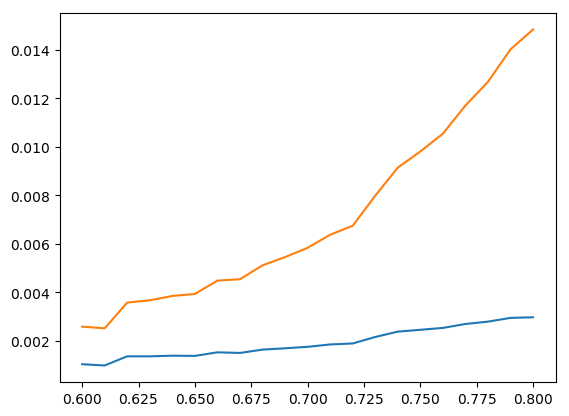

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000001FA95358>

In [13]:
plot(omegaEpsilonGrid, perDefaultingThisYear, label = "% Defaulting")
plot(omegaEpsilonGrid, perThreatening, label = "% Threatening")
 

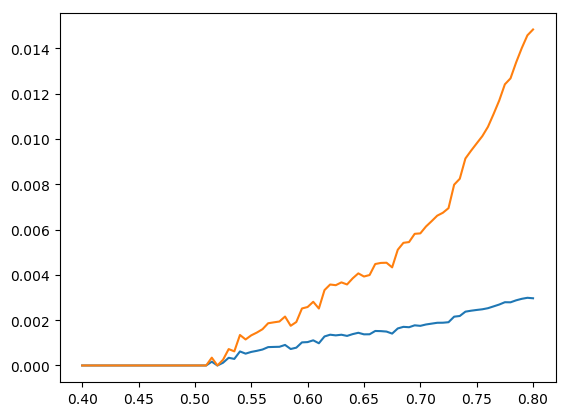

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002022A438>

In [15]:
plot(omegaEpsilonGrid, perDefaultingThisYear, label = "% Defaulting")
plot(omegaEpsilonGrid, perThreatening, label = "% Threatening")

In [13]:
nGridBonds = 1.7
vGridBonds = collect(.01:.01:1.7)
phi = .62
restructure(1.6)


LoadError: MethodError: Cannot `convert` an object of type Float64 to an object of type Array{Float64,N}
This may have arisen from a call to the constructor Array{Float64,N}(...),
since type constructors fall back to convert methods.

In [51]:

function findBond(bonds)
    differenceSq = zeros(nGridBonds)
    for currentDebt = 1:nGridBonds
        differenceSq[currentDebt] = abs(vGridBonds[currentDebt] - bonds)
    end
    global findBondIndex = findmin(differenceSq)[2]
    global findBondGrow = findmin(differenceSq)[1]
end 

findBond (generic function with 1 method)

In [56]:
findBond(1.2)
findBondIndex

129